In [1]:
from pathlib import Path
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.colors
import matplotlib.cm

import numpy as np
import numpy

import torch
import torch.nn as nn

In [2]:
BINS = 256
LAYERS = [(100, 30), (30, 30), (30, 30), (30, 10)]
ACTIVATION = nn.Sigmoid()
RUNS = 3
FREQUENCY = 5 # epochs per measurement
EPOCHS = 500
BATCH_SIZE = 50

top_str = ""
for i, l in enumerate(LAYERS):
    if i == len(LAYERS)-1:
        in_w = l[0]
        out_w = l[1]
        top_str += f"{in_w}-{out_w}"
    else:
        in_w = l[0]
        out_w = l[1]
        top_str += f"{in_w}-"

In [3]:
here = Path()
run_folders = [here / f"run{i}-frames" for i in range(1, RUNS+1)]
runs_frames = [list(run.glob('*.frame')) for run in run_folders]

In [4]:
figures = here / f"figures_{top_str}"
if not figures.exists():
    figures.mkdir()

In [5]:
# Pretty colormaps
def greyscaleMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("binary")
    return colormap((((0.6 / size * pos) + 0.1)))
                    
def rainbowMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("rainbow")
    return colormap(1.0 * pos / size)

def makeColor(collection, item, cmap = "rainbow"):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap(cmap)
    return colormap((((0.6 / size * pos) + 0.3)))

def infernoMap(i, n): # i = 1, 2, ... n
    colormap = matplotlib.cm.get_cmap("inferno")
    return colormap((1.0 * i / n)*0.6 + 0.0)

In [6]:
def get_measures(path_to_frame):
    frame = torch.load(path_to_frame)
    measure_names = [
        'batches',
        'epochs',
        'training_loss',
        'testing_loss',
        'training_accuracy',
        'testing_accuracy',
    ]
    for i in range(1, len(LAYERS)+1):
        measure_names.append(f"ei_layer{i}")
        measure_names.append(f"sensitivity_layer{i}")
    measures = {}
    for name in measure_names:
        if type(frame[name]) is torch.Tensor:
            measures[name] = frame[name].item()
        else:
            measures[name] = frame[name]
    return measures

In [7]:
runs_datapoints = [[get_measures(path) for path in run_frames] for run_frames in runs_frames]
for run_datapoints in runs_datapoints:
    run_datapoints.sort(key=lambda f: f['batches'])

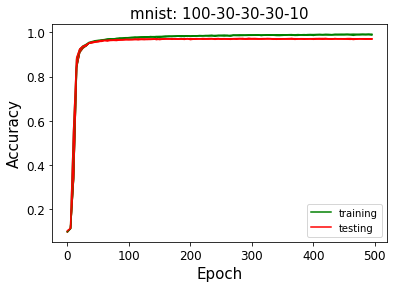

In [8]:
fig, ax = matplotlib.pyplot.subplots(1,1)
for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    training_accuracies = [f['training_accuracy'] for f in run]
    testing_accuracies = [f['testing_accuracy'] for f in run]
    if i == 0:
        plt.plot(epochs, training_accuracies, color='green', alpha=1, label='training')
        plt.plot(epochs, testing_accuracies, color='red', alpha=1, label='testing')
    else:
        plt.plot(epochs, training_accuracies, color='green', alpha=1)
        plt.plot(epochs, testing_accuracies, color='red', alpha=1)
plt.title(f"mnist: {top_str}", fontsize=15)
ax.set_xlabel('Epoch',fontsize=15)
ax.set_ylabel('Accuracy',fontsize=15)
ax.tick_params(axis='both',which='major',labelsize=12)
plt.legend(loc='lower right')
plt.savefig(f"{figures}/mnist_{top_str}_accuracies.png", dpi=300, bbox_inches='tight')

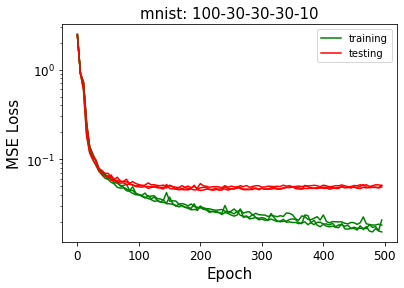

In [9]:
fig, ax = matplotlib.pyplot.subplots(1,1)
for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    training_losses = [f['training_loss'] for f in run]
    testing_losses = [f['testing_loss'] for f in run]
    if i == 0:
        plt.plot(epochs, training_losses, color='green', label='training', alpha=1)
        plt.plot(epochs, testing_losses, color='red', label='testing', alpha=1)
    else:
        plt.plot(epochs, training_losses, color='green', alpha=1)
        plt.plot(epochs, testing_losses, color='red', alpha=1)
plt.title(f"mnist: {top_str}", fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_ylabel('MSE Loss', fontsize=15)
ax.tick_params(axis='both',which='major',labelsize=12)
plt.legend(loc='upper right')
plt.yscale('log')
plt.savefig(f"{figures}/mnist_{top_str}_losses.png", dpi=300, bbox_inches='tight')

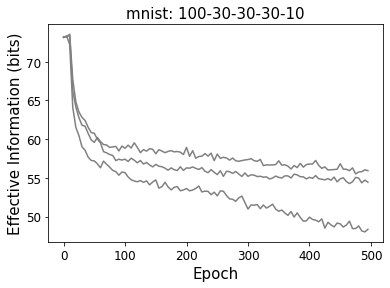

In [10]:
fig, ax = matplotlib.pyplot.subplots(1,1)
eis_each_run = []
for run in runs_datapoints:
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    layer_eis = []
    for i in range(1, len(LAYERS)+1):
        layer_eis.append(np.array([f[f"ei_layer{i}"] for f in run]))
    eis_each_run.append(layer_eis)
        
total_eis = []
for run_eis in eis_each_run:
    tot = 0
    for layer_eis in run_eis:
        tot += layer_eis
    total_eis.append(tot)

for i, ei in enumerate(total_eis):
    epochs = [f['epochs'] for f in runs_datapoints[i]]
    plt.plot(epochs, ei, color='grey')#color=infernoMap(1, 3))

plt.title(f"mnist: {top_str}", fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_ylabel('Effective Information (bits)', fontsize=15)
ax.tick_params(axis='both',which='major',labelsize=12)
# plt.legend(loc='lower right')
# plt.legend()
plt.savefig(f"{figures}/mnist_{top_str}_eis_total.png", dpi=300, bbox_inches='tight')

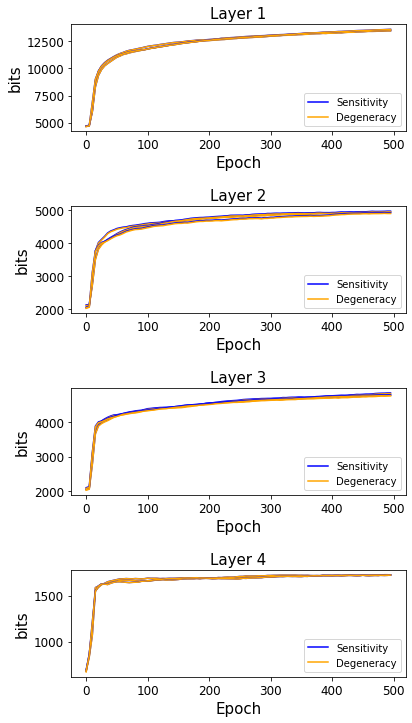

In [11]:
fig, axes = matplotlib.pyplot.subplots(len(LAYERS), 1, figsize=(6, 12))

for l in range(1, len(LAYERS)+1):
#     plt.subplot(len(LAYERS), l, 1)
    ax = axes[l-1]
    for i, run in enumerate(runs_datapoints):
        epochs = np.array([f['epochs'] for f in run])
        ei_layer = np.array([f[f"ei_layer{l}"] for f in run])
        sensitivity_layer = np.array([f[f"sensitivity_layer{l}"] for f in run])
        degeneracy_layer = sensitivity_layer - ei_layer
        line, = ax.plot(epochs, sensitivity_layer, c='blue')#infernoMap(1, 2))
        if i == 0:
            line.set_label("Sensitivity")
        line, = ax.plot(epochs, degeneracy_layer, c='orange')#infernoMap(2, 2))
        if i == 0:
            line.set_label("Degeneracy")    
    ax.set_title(f"Layer {l}", fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_ylabel('bits', fontsize=15)
    ax.tick_params(axis='both',which='major',labelsize=12)
    ax.legend()

plt.subplots_adjust(hspace=0.7)
plt.savefig(f"{figures}/mnist_{top_str}_sens_degens_each.png", dpi=300, bbox_inches='tight')

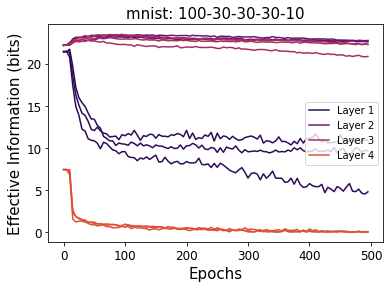

In [12]:
fig, ax = matplotlib.pyplot.subplots(1,1)  

for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    for l in range(1, len(LAYERS)+1):
        ei_layer = np.array([f[f"ei_layer{l}"] for f in run])
        line, = ax.plot(epochs, ei_layer, c=infernoMap(l, len(LAYERS)))
        if i == 0:
            line.set_label(f"Layer {l}")

#ax.set_xlabel('Epoch',fontsize=15)    
ax.set_xlabel("Epochs", fontsize = 15)
ax.set_ylabel('Effective Information (bits)',fontsize=15)
ax.set_title(f"mnist: {top_str}", fontsize=15)
# ax.set_xlim([-3, 13])
# ax.set_ylim([5,25])
#ax.set_ylim([0,70])
# Plot a vertical line!
# noEIChange, = ax.plot([0,0],[200,1600],c = 'black', label="EI nullcline")
# noEIChange, = ax.plot([0,0],[2,6], c='black')
# noEIChange.set_label("EI nullcline")
# Plot the legend!
# fig.legend(loc=(.18,0.66),prop={'size':10})
# fig.legend(loc=(.17, 0.72),prop={'size':10})
ax.legend()
ax.tick_params(axis='both',which='major',labelsize=12)
plt.savefig(f"{figures}/mnist_{top_str}_eis_each.png", dpi=300, bbox_inches='tight')

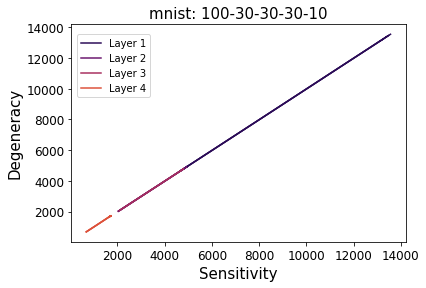

In [13]:
fig, ax = matplotlib.pyplot.subplots(1,1)  

for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    for l in range(1, len(LAYERS)+1):
        ei_layer = np.array([f[f"ei_layer{l}"] for f in run])
        sensitivity_layer = np.array([f[f"sensitivity_layer{l}"] for f in run])
        degeneracy_layer = sensitivity_layer - ei_layer
        line, = ax.plot(sensitivity_layer, degeneracy_layer, c=infernoMap(l, len(LAYERS)))
        if i == 0:
            line.set_label(f"Layer {l}")

#ax.set_xlabel('Epoch',fontsize=15)    
ax.set_xlabel("Sensitivity", fontsize = 15)
ax.set_ylabel('Degeneracy',fontsize=15)
ax.set_title(f"mnist: {top_str}", fontsize=15)
# ax.set_xlim([-3, 13])
# ax.set_ylim([5,25])
#ax.set_ylim([0,70])
# Plot a vertical line!
# noEIChange, = ax.plot([0,0],[200,1600],c = 'black', label="EI nullcline")
# noEIChange, = ax.plot([0,0],[2,6], c='black')
# noEIChange.set_label("EI nullcline")
# Plot the legend!
fig.legend(loc=(.18,0.66),prop={'size':10})
# fig.legend(loc=(.17, 0.72),prop={'size':10})
# fig.legend()
ax.tick_params(axis='both',which='major',labelsize=12)
#fig.legend(loc='upper left')
plt.savefig(f"{figures}/mnist_{top_str}_nonrotated.png", dpi=300, bbox_inches='tight')

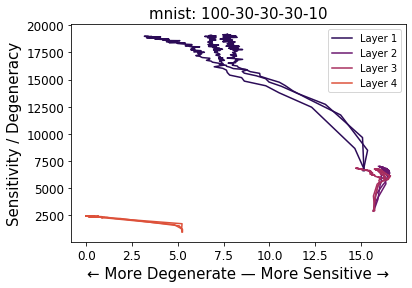

In [14]:
fig, ax = matplotlib.pyplot.subplots(1,1) 

for l in range(1, len(LAYERS)+1):
    for i, run in enumerate(runs_datapoints):
        ei_layer = np.array([f[f"ei_layer{l}"] for f in run])
        sensitivity_layer = np.array([f[f"sensitivity_layer{l}"] for f in run])
        degeneracy_layer = sensitivity_layer - ei_layer
        xS = sensitivity_layer
        yS = degeneracy_layer
        xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
        yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
        line, = ax.plot(xPrime, yPrime, c=infernoMap(l, len(LAYERS))) #alpha=0.25+0.37*i)
        if i == 0:
            line.set_label(f"Layer {l}")
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=15)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 15)
plt.title(f"mnist: {top_str}", fontsize=15)
ax.tick_params(axis='both',which='major',labelsize=12)
ax.legend()
# plt.savefig("figures/iris_plane_all_correct.png", dpi=300, bbox_inches='tight')


# #ax.set_xlabel('Epoch',fontsize=15)            
# ax.set_ylabel('Sensitivity / Degeneracy',fontsize=15)
# ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 15)
# plt.title("IRIS w/ Correct Labels", fontsize=15)
# ax.tick_params(axis='both',which='major',labelsize=12)
# ax.set_xlim([-2, 14])
# # ax.set_ylim([5,25])
# #ax.set_ylim([0,70])
# # Plot a vertical line!
# noEIChange, = ax.plot([0,0],[250, 1650], c = 'black', label='EI nullcline')
# # noEIChange, = ax.plot([0,0],[2,6], c='black')
# # noEIChange.set_label("EI nullcline")
# # Plot the legend!
# fig.legend(loc=(.27,0.66),prop={'size':10})
# #fig.legend(loc=(.135,0.645),prop={'size':10})
plt.savefig(f"{figures}/mnist_{top_str}_plane.png", dpi=300, bbox_inches='tight')

In [15]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

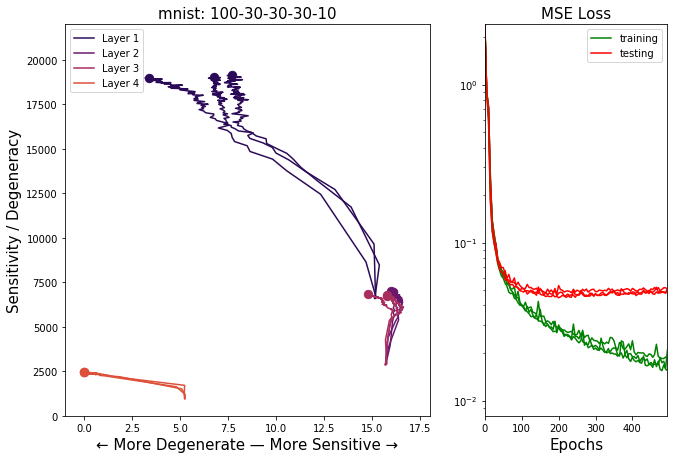

In [16]:
LENGTH = len(runs_datapoints[0])

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"mnist: {top_str}", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=8, metadata=metadata)

fig, (ax, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=(10.8, 7.2))
ax.set_title(f"mnist: {top_str}", fontsize=15)
ax.set_ylabel('Sensitivity / Degeneracy', fontsize=15)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize=15)
ax.set_xlim([-1, 18])
ax.set_ylim([0, 22000])
ax2.set_xlabel("Epochs", fontsize=15)
ax2.set_title("MSE Loss", fontsize=15)
# ax2.set_yscale('log')
# Plot a vertical line!
#noEIChange, = ax.plot([0,0],[-10,80],c = 'black')
# noEIChange, = ax.plot([0,0],[2,6], c='black')
# noEIChange.set_label("EI nullcline")
# Plot the legend!
# fig.legend(loc=(.18,0.645),prop={'size':10})
#fig.legend(loc=(.135,0.645),prop={'size':10})

layer_lines = {}
layer_dots = {}
for l in range(1, len(LAYERS)+1):
    layer_lines[f"layer{l}"] = []
    layer_dots[f"layer{l}"] = []
    for i in range(RUNS):
        if i == 0:
            layer_lines[f"layer{l}"].append(ax.plot([], [], c=infernoMap(l, len(LAYERS)), label=f"Layer {l}")[0])
            layer_dots[f"layer{l}"].append(ax.scatter([], [], c=infernoMap(l, len(LAYERS)), s=70))
        else:
            layer_lines[f"layer{l}"].append(ax.plot([], [], c=infernoMap(l, len(LAYERS)))[0])
            layer_dots[f"layer{l}"].append(ax.scatter([], [], c=infernoMap(l, len(LAYERS)), s=70))

tr_loss_lines = []
te_loss_lines = []
for i in range(RUNS):
    if i == 0:
        tr_loss_lines.append(ax2.plot([], [], c='green', label='training')[0])
        te_loss_lines.append(ax2.plot([], [], c='red', label='testing')[0])
    else:
        tr_loss_lines.append(ax2.plot([], [], c='green')[0])
        te_loss_lines.append(ax2.plot([], [], c='red')[0])


# s = ax.scatter(xPrime[n:n+1], yPrime[n:n+1], c='purple', s=70)
# line, = ax.plot(xPrime[0:n+1], yPrime[0:n+1], c='purple')

with writer.saving(fig, f"{figures}/mnist_{top_str}_plane_video.mp4", dpi=200):
    for n in range(LENGTH):
        for i, run in enumerate(runs_datapoints):
            epochs = [f['epochs'] for f in run]
            training_loss = np.array([f['training_loss'] for f in run])
            testing_loss = np.array([f['testing_loss'] for f in run])
            tr_loss_lines[i].set_data(epochs[0:n+1], training_loss[0:n+1])
            te_loss_lines[i].set_data(epochs[0:n+1], testing_loss[0:n+1])
            ax2.set_xlim(0, epochs[n])
            ax2.set_yscale('log')
            ax2.set_ylim(min(testing_loss.min(), training_loss.min())/2, max(testing_loss.max(), training_loss.max()))
            ax2.legend(loc="upper right")
            for l in range(1, len(LAYERS)+1):
                ei_layer = np.array([f[f'ei_layer{l}'] for f in run])
                sensitivity_layer = np.array([f[f'sensitivity_layer{l}'] for f in run])
                degeneracy_layer = sensitivity_layer - ei_layer
                xS = sensitivity_layer
                yS = degeneracy_layer
                xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)])
                yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)])
                layer_lines[f"layer{l}"][i].set_data(xPrime[0:n+1], yPrime[0:n+1])
                layer_dots[f"layer{l}"][i].set_offsets([xPrime[n], yPrime[n]])
            ax.legend(loc="upper left")
        writer.grab_frame()
plt.subplots_adjust(wspace=0.2)
#             ss[i].set_offsets([xPrime[n], yPrime[n]])
#             lines[i].set_data(xPrime[0:n+1], yPrime[0:n+1])
#         tr_ls.set_data(batches[0:n+1], training_loss[0:n+1])
#         te_ls.set_data(batches[0:n+1], testing_loss[0:n+1])
        #     if i == 0:
        #         line.set_label("1")
        #     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
        #ax.set_xlabel('Epoch',fontsize=15)            
        
        
#         fig, ax = matplotlib.pyplot.subplots(1,1)